In [18]:
import os
import pickle
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
import tensorboard as tb
from tensorboard.backend.event_processing import event_accumulator
from random import choices
from itertools import combinations

In [19]:
def age_debiasing(predicted_ages, chronological_ages):
    
    predicted_ages = predicted_ages.to_numpy()
    chronological_ages = chronological_ages.to_numpy()
    
    ones = np.ones(len(chronological_ages))
    chronological_ages_squared = np.square(chronological_ages)
    chronological_ages_confounds = np.array([ones, chronological_ages])
    
    ones_predicted = np.ones(len(predicted_ages))
    predicted_ages_squared = np.square(predicted_ages)
    predicted_ages_confounds = np.array([ones_predicted, predicted_ages])
    
    predicted_ages = np.reshape(predicted_ages, (len(predicted_ages), 1) )
    beta = np.dot( np.linalg.pinv(chronological_ages_confounds.T), predicted_ages )

    corrected_predicted_ages = (predicted_ages.flatten() - beta[0])/beta[1]
    
    return corrected_predicted_ages

def age_debiasing(predicted_ages, chronological_ages):
    
    predicted_ages = predicted_ages.to_numpy()
    chronological_ages = chronological_ages.to_numpy()
    
    ones = np.ones(len(chronological_ages))
    chronological_ages_squared = np.square(chronological_ages)
    chronological_ages_confounds = np.array([ones, chronological_ages])
    
    ones_predicted = np.ones(len(predicted_ages))
    predicted_ages_squared = np.square(predicted_ages)
    predicted_ages_confounds = np.array([ones_predicted, predicted_ages])
    
    predicted_ages = np.reshape(predicted_ages, (len(predicted_ages), 1) )
    beta = np.dot( np.linalg.pinv(chronological_ages_confounds.T), predicted_ages )

    corrected_predicted_ages = (predicted_ages.flatten() - beta[0])/beta[1]
    
    return corrected_predicted_ages

def tensorboard_reader(directory, tag='AgeDelta/epoch'):
    """
    Sources: 
    https://stackoverflow.com/questions/41074688/how-do-you-read-tensorboard-files-programmatically
    https://stackoverflow.com/questions/37304461/tensorflow-importing-data-from-a-tensorboard-tfevent-file
    """
    
    for dataset in ['train', 'validation']:
    
        dct = {}
        steps = []
        values = []
    
        if dataset == 'train':
            dir_name = directory + '/train/'
        else:
            dir_name = directory + '/validation/'

        list_of_files = os.listdir(dir_name)

        for file in list_of_files:
            file_name=dir_name+file
#             print(file_name)
            ea = event_accumulator.EventAccumulator(file_name,
              size_guidance={
              event_accumulator.COMPRESSED_HISTOGRAMS: 500,
              event_accumulator.IMAGES: 4,
              event_accumulator.AUDIO: 4,
              event_accumulator.SCALARS: 0,
              event_accumulator.HISTOGRAMS: 1,
          })
            ea.Reload()
#             print(ea.Tags())
            if tag in ea.Tags()['scalars']:
                for e in ea.Scalars(tag):
                    step = e.step
                    value = e.value
                    steps.append(step)
                    values.append(value)

        dct['step'] = steps
        
        if dataset == 'train':
            dct['train'] = values
            dfp = pd.DataFrame.from_dict(dct)
        else:
            dct['validation'] = values
            dfv = pd.DataFrame.from_dict(dct)

    df = pd.merge(dfp, dfv, how='left', on='step')
    df = df.sort_values('step')
    
    return df

def linear_plotter(x, y_train, y_validation, xlabel, ylabel, title, ylim_flag=False, xlim=None):
    
    if isinstance(x, np.ndarray):
        pass
    else:
        x = x.values
        y_train = y_train.values
        y_validation = y_validation.values
    
    plt.figure(figsize=[14.4,7.2])
    plt.plot(x, y_train, label='Train')
    plt.plot(x, y_validation, label='Validation')
    plt.xlabel(xlabel)
    if ylim_flag == True:
        ylim_min = -0.25
        ylim_max = np.max(y_train) + 5
        plt.ylim((ylim_min, ylim_max))
    best_validation = np.min(y_validation)
    best_epoch = x[np.where(y_validation == np.min(y_validation))[0][0]]
    best_train = y_train[np.where(y_validation == np.min(y_validation))[0][0]]
    gap = best_train - best_validation
    print(best_epoch, best_validation)
    print(-gap)
    plt.scatter(x=best_epoch, y=best_validation, s=100, marker='*', color='red', label='Selected Best Epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    if xlim is not None:
        plt.xlim(xlim)
    plt.show()
    
def linear_plotter_comparison(Xs, Ys, Labels,
                              xlabel, ylabel, title, ylim_flag=False):
    
    plt.figure(figsize=[7,5])
    for idx, x in enumerate(Xs):
        plt.plot(x, Ys[idx], label=Labels[idx])
    plt.xlabel(xlabel)
    if ylim_flag == True:
        ylim_min = -0.25
        y_max = [np.max(Ys[idx]) for idx in range(len(Ys))]
        ylim_max = min(y_max)
        plt.ylim((ylim_min, ylim_max))
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()
    
def plot_everything(network='49', ylim2=[2.175, 2.45], control=False):
    dfs = []
    names = []
    range_points = [1,2,3]
#     network = '49'
    preambul = 'MM'
    if control == True:
        preambul = 'AM'
        range_points = [10,11,12]

    tag = 'AgeDelta/epoch'
    for i in range_points:
        name = preambul + str(int(i)) + '-' + network
        directory = '../logs/' + name
        df = tensorboard_reader(directory=directory, tag=tag)
        dfs.append(df)
        names.append(name)

    dfs2 = []
    names2 = []
    range_points = [1,2,3]
#     network = '49'

    tag2 = 'LearningRate/iteration'
    for i in range_points:
        name2 = preambul + str(int(i)) + '-' + network
        directory2 = '../logs/' + name
    #     if os.path.isdir(directory):
        df2 = tensorboard_reader(directory=directory2, tag=tag2)
        dfs2.append(df2)
        names2.append(name2)

    for i, df in enumerate(dfs):
        name = names[i]
        df = df.dropna(axis=0)
        linear_plotter(x=df.step, y_train=df.train, y_validation=df.validation, 
                       xlabel='Epochs', ylabel=tag, title=name, xlim=[-2, 300])

    Xs = [dfs[i].step.values for i in range(len(dfs))]
    Ys = [dfs[i].validation.values for i in range(len(dfs))]
    Labels = [preambul + str(int(i)) + '-' + network for i in range_points]
    xlabel='Epochs'
    ylabel='AgeDelta/epoch'

    plt.figure(figsize=[14.4,7.2])
    for idx, x in enumerate(Xs):
        y = Ys[idx]
        x = np.delete(x, np.argwhere(np.isnan(y)))
        y = np.delete(y, np.argwhere(np.isnan(y)))
        plt.plot(x, y, label=Labels[idx], alpha=0.3)
        best_validation = np.min(y)
        best_epoch = x[np.where(y == np.min(y))[0][0]]
        label = 'Selected Best Epoch for ' + Labels[idx]
        if idx < 3:
            plt.scatter(x=best_epoch, y=best_validation, s=150, marker='*', label=label)
        else:
            plt.scatter(x=best_epoch, y=best_validation, s=150, marker='o', label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.ylim(ylim2)
    plt.xlim([-1,300])
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')

#     for idx in range(len(dfs2)):
#         dfs2[idx].step = dfs2[idx].step / (dfs2[idx].step.max() / dfs[idx].step.max())

#     ncols=2
#     nrows=1
#     sz=7.2
#     title_font_size=22
#     ticks_font_size=18
#     legend_font = 18

#     for idx in range(len(dfs)):

#         fig, axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(ncols*sz,nrows*sz))

#         axes = axes.ravel()

#         axes[0] = plt.subplot()
#         ax2 = axes[0].twinx()
#         l1, = axes[0].plot(dfs[idx].step, dfs[idx].validation, color='tab:orange')
#         l2, = ax2.plot(dfs2[idx].step, dfs2[idx].train, linestyle='dotted', color='b')

#         best_validation = np.min(dfs[idx].validation.values)
#         best_epoch = dfs[idx].step.values[np.where(dfs[idx].validation.values == best_validation)[0][0]]
#         l3 = axes[0].scatter(x=best_epoch, y=best_validation, s=100, marker='*', color='red')


#         plt.legend([l1, l2, l3], ['Val Curve', 'LR', 'Selected Best Epoch'])




#         axes[0].set_ylabel('Age Delta')
#         ax2.set_ylabel('Learning Rate')
#         axes[0].set_xlabel('Training Epochs')
#         ax2.grid(linestyle='--')

#         axes[0].set_xlim([-2, 300])

In [20]:
!ls '../../agemapper/'

Analsysis Female New
Analysis - SFCN vs HGL
Analysis Male New
Analysis Project 2
Analysis_data
MRI-based age prediction using hidden Markov models - ScienceDirect.html
additional_codes
data_examples
figures
logs
multi-age-mapper
predictions


In [21]:
df = pd.read_pickle('../../agemapper/Analsysis Female New/female_test.pkl')
df_test = {}
df_test['Unnamed: 0'] = df.iloc[0].dataframe['Unnamed: 0'].to_list()
for idx in range(len(df)):
    name = df.iloc[idx].modality
    data = df.iloc[idx].dataframe.mean_output_age.to_list()
    df_test[name] = data
    
df_test = pd.DataFrame.from_dict(df_test)
df_test['target_age'] = df.iloc[0].dataframe.target_age.to_list()

df_testA, df_testB = train_test_split(df_test, test_size=0.5, random_state=1)
subjectsA = df_testA['Unnamed: 0'].to_list()
subjectsB = df_testB['Unnamed: 0'].to_list()
del df_testA, df_testB, df

In [22]:

net1 = "1" # T1NL
net2 = '2' # T2NL
net3 = '3' # FA
net4 = "4" # MD
net5 = '5' # rsfMRI 0
net6 = '6' # SWI
net7 = "7" # tfMRI 1
net8 = '8' # dmri tracts
net9 = '9' # MO
net10 = "10" # TBSS ISOVF
net11 = '11' # L2
net12 = '12' # rsfMRI 2
net13 = "13" # rsfMRI 10
net14 = '14' # rsfMRI 5
net15 = '15' # rsfMRI 21
net16 = "16" # T2 Lessions
net17 = '17' # TBSS FA
net18 = '18' # TBSS L3

dfs = [
    net1,
    net2,
    net3,
    net4,
    net5,
    net6,
    net7,
    net8,
    net9,
    net10,
    net11,
    net12,
    net13,
    net14,
    net15,
    net16,
    net17,
    net18
]

names = [

    'T1_nonlinear',           #1
    'T2_nonlinear',           #2
    'tbss_FA',                #3
    'tbss_MD',                #4
    'rsfmri_0',               #5
    'swi',                    #6
    'tfmri_1',                #7
    'tracts',                 #8
    'tbss_MO',                #9
    'tbss_ISOVF_s',           #10
    'tbss_L2',                #11
    'rsfmri_2',               #12
    'rsfmri_10',              #13
    'rsfmri_5',               #14
    'rsfmri_21',              #15
    'T2_lessions',            #16
    'tbss_FA_s',              #17
    'tbss_L3_s',              #18
    
]
    

dfs1, dfs2, dfs3 = [], [], []
dfs4, dfs5, dfs6 = [], [], []
dfs7, dfs8, dfs9 = [], [], []

dfs1 = dfs.copy()
dfs2 = dfs.copy()
dfs3 = dfs.copy()
dfs4 = dfs.copy()
dfs5 = dfs.copy()
dfs6 = dfs.copy()
dfs7 = dfs.copy()
dfs8 = dfs.copy()
dfs9 = dfs.copy()


for idx in range(len(dfs)):
    
    dfs1[idx] = '../predictions/AC1-' + dfs1[idx] + '_predictions/output_statistics_test.csv'
    dfs2[idx] = '../predictions/AC2-' + dfs2[idx] + '_predictions/output_statistics_test.csv'
    dfs3[idx] = '../predictions/AC3-' + dfs3[idx] + '_predictions/output_statistics_test.csv'
    dfs4[idx] = '../predictions/AC4-' + dfs4[idx] + '_predictions/output_statistics_test.csv'
    dfs5[idx] = '../predictions/AC5-' + dfs5[idx] + '_predictions/output_statistics_test.csv'
    dfs6[idx] = '../predictions/AC6-' + dfs6[idx] + '_predictions/output_statistics_test.csv'
    dfs7[idx] = '../predictions/AC7-' + dfs7[idx] + '_predictions/output_statistics_test.csv'
    dfs8[idx] = '../predictions/AC8-' + dfs8[idx] + '_predictions/output_statistics_test.csv'
    dfs9[idx] = '../predictions/AC9-' + dfs9[idx] + '_predictions/output_statistics_test.csv'

    
for idx in range(len(dfs)):
    dfs1[idx] = pd.read_csv(dfs1[idx])
    dfs2[idx] = pd.read_csv(dfs2[idx])
    dfs3[idx] = pd.read_csv(dfs3[idx])
    dfs4[idx] = pd.read_csv(dfs4[idx])
    dfs5[idx] = pd.read_csv(dfs5[idx])
    dfs6[idx] = pd.read_csv(dfs6[idx])
    dfs7[idx] = pd.read_csv(dfs7[idx])
    dfs8[idx] = pd.read_csv(dfs8[idx])
    dfs9[idx] = pd.read_csv(dfs9[idx])

subjects = subjectsA

for idx in range(len(dfs)):
    for subj in dfs1[idx]['Unnamed: 0'].to_list():
        if subj not in subjects:
            dfs1[idx] = dfs1[idx].drop(dfs1[idx][dfs1[idx]['Unnamed: 0'] == subj].index)
            dfs2[idx] = dfs2[idx].drop(dfs2[idx][dfs2[idx]['Unnamed: 0'] == subj].index)
            dfs3[idx] = dfs3[idx].drop(dfs3[idx][dfs3[idx]['Unnamed: 0'] == subj].index)
            dfs4[idx] = dfs4[idx].drop(dfs4[idx][dfs4[idx]['Unnamed: 0'] == subj].index)
            dfs5[idx] = dfs5[idx].drop(dfs5[idx][dfs5[idx]['Unnamed: 0'] == subj].index)
            dfs6[idx] = dfs6[idx].drop(dfs6[idx][dfs6[idx]['Unnamed: 0'] == subj].index)
            dfs7[idx] = dfs7[idx].drop(dfs7[idx][dfs7[idx]['Unnamed: 0'] == subj].index)
            dfs8[idx] = dfs8[idx].drop(dfs8[idx][dfs8[idx]['Unnamed: 0'] == subj].index)
            dfs9[idx] = dfs9[idx].drop(dfs9[idx][dfs9[idx]['Unnamed: 0'] == subj].index)
    
    
for idx in range(len(dfs)):
    dfs[idx] = pd.merge(dfs1[idx], dfs2[idx], on='Unnamed: 0', how='inner')
    dfs[idx] = pd.merge(dfs[idx], dfs3[idx], on='Unnamed: 0', how='inner')
    
    dfs[idx].rename({
        'target_age_x': 'target_age_original',
        'output_age_x': 'output_age_1',
        'age_delta_x': 'age_delta_1',
        'loss_x': 'loss_1',
        'target_age_y': 'target_age_2',
        'output_age_y': 'output_age_2',
        'age_delta_y': 'age_delta_2',
        'loss_y': 'loss_2',
        'target_age': 'target_age_3',
        'output_age': 'output_age_3',
        'age_delta': 'age_delta_3',
        'loss': 'loss_3',
    }, axis=1, inplace=True)
    
    dfs[idx].drop(['target_age_2', 'target_age_3'], axis=1, inplace=True)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs4[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_4',
        'age_delta': 'age_delta_4',
        'loss': 'loss_4',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs5[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_5',
        'age_delta': 'age_delta_5',
        'loss': 'loss_5',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs6[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_6',
        'age_delta': 'age_delta_6',
        'loss': 'loss_6',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
      
    
    dfs[idx] = pd.merge(dfs[idx], dfs7[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_7',
        'age_delta': 'age_delta_7',
        'loss': 'loss_7',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs8[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_8',
        'age_delta': 'age_delta_8',
        'loss': 'loss_8',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs9[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_9',
        'age_delta': 'age_delta_9',
        'loss': 'loss_9',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    dfs[idx].rename({
        'target_age_original': 'target_age',
    }, axis=1, inplace=True)
    
    dfs[idx]['mean_output_age'] = dfs[idx][['output_age_1', 'output_age_2', 'output_age_3',
                                           'output_age_4', 'output_age_5', 'output_age_6',
                                           'output_age_7', 'output_age_8', 'output_age_9',
                                           ]].mean(axis=1)
    dfs[idx]['mean_age_delta'] = dfs[idx]['mean_output_age'] - dfs[idx]['target_age']
    
for idx in range(len(dfs)):    
    dfs[idx]['output_age_decon'] = age_debiasing(dfs[idx].mean_output_age, dfs[idx].target_age) 
    dfs[idx]['age_delta_decon'] = dfs[idx].output_age_decon - dfs[idx].target_age

d = {'modality':names, 'dataframe':dfs}
df = pd.DataFrame(data=d)
df.to_pickle('female_test_testA_convergence9.pkl', protocol = 4)

In [23]:

net1 = "1" # T1NL
net2 = '2' # T2NL
net3 = '3' # FA
net4 = "4" # MD
net5 = '5' # rsfMRI 0
net6 = '6' # SWI
net7 = "7" # tfMRI 1
net8 = '8' # dmri tracts
net9 = '9' # MO
net10 = "10" # TBSS ISOVF
net11 = '11' # L2
net12 = '12' # rsfMRI 2
net13 = "13" # rsfMRI 10
net14 = '14' # rsfMRI 5
net15 = '15' # rsfMRI 21
net16 = "16" # T2 Lessions
net17 = '17' # TBSS FA
net18 = '18' # TBSS L3

dfs = [
    net1,
    net2,
    net3,
    net4,
    net5,
    net6,
    net7,
    net8,
    net9,
    net10,
    net11,
    net12,
    net13,
    net14,
    net15,
    net16,
    net17,
    net18
]

names = [

    'T1_nonlinear',           #1
    'T2_nonlinear',           #2
    'tbss_FA',                #3
    'tbss_MD',                #4
    'rsfmri_0',               #5
    'swi',                    #6
    'tfmri_1',                #7
    'tracts',                 #8
    'tbss_MO',                #9
    'tbss_ISOVF_s',           #10
    'tbss_L2',                #11
    'rsfmri_2',               #12
    'rsfmri_10',              #13
    'rsfmri_5',               #14
    'rsfmri_21',              #15
    'T2_lessions',            #16
    'tbss_FA_s',              #17
    'tbss_L3_s',              #18
    

]
    
dfs1, dfs2, dfs3 = [], [], []
dfs4, dfs5, dfs6 = [], [], []
dfs7, dfs8, dfs9 = [], [], []

dfs1 = dfs.copy()
dfs2 = dfs.copy()
dfs3 = dfs.copy()
dfs4 = dfs.copy()
dfs5 = dfs.copy()
dfs6 = dfs.copy()
dfs7 = dfs.copy()
dfs8 = dfs.copy()
dfs9 = dfs.copy()


for idx in range(len(dfs)):
    
    dfs1[idx] = '../predictions/AC1-' + dfs1[idx] + '_predictions/output_statistics_test.csv'
    dfs2[idx] = '../predictions/AC2-' + dfs2[idx] + '_predictions/output_statistics_test.csv'
    dfs3[idx] = '../predictions/AC3-' + dfs3[idx] + '_predictions/output_statistics_test.csv'
    dfs4[idx] = '../predictions/AC4-' + dfs4[idx] + '_predictions/output_statistics_test.csv'
    dfs5[idx] = '../predictions/AC5-' + dfs5[idx] + '_predictions/output_statistics_test.csv'
    dfs6[idx] = '../predictions/AC6-' + dfs6[idx] + '_predictions/output_statistics_test.csv'
    dfs7[idx] = '../predictions/AC7-' + dfs7[idx] + '_predictions/output_statistics_test.csv'
    dfs8[idx] = '../predictions/AC8-' + dfs8[idx] + '_predictions/output_statistics_test.csv'
    dfs9[idx] = '../predictions/AC9-' + dfs9[idx] + '_predictions/output_statistics_test.csv'

    
for idx in range(len(dfs)):
    dfs1[idx] = pd.read_csv(dfs1[idx])
    dfs2[idx] = pd.read_csv(dfs2[idx])
    dfs3[idx] = pd.read_csv(dfs3[idx])
    dfs4[idx] = pd.read_csv(dfs4[idx])
    dfs5[idx] = pd.read_csv(dfs5[idx])
    dfs6[idx] = pd.read_csv(dfs6[idx])
    dfs7[idx] = pd.read_csv(dfs7[idx])
    dfs8[idx] = pd.read_csv(dfs8[idx])
    dfs9[idx] = pd.read_csv(dfs9[idx])

subjects = subjectsB

for idx in range(len(dfs)):
    for subj in dfs1[idx]['Unnamed: 0'].to_list():
        if subj not in subjects:
            dfs1[idx] = dfs1[idx].drop(dfs1[idx][dfs1[idx]['Unnamed: 0'] == subj].index)
            dfs2[idx] = dfs2[idx].drop(dfs2[idx][dfs2[idx]['Unnamed: 0'] == subj].index)
            dfs3[idx] = dfs3[idx].drop(dfs3[idx][dfs3[idx]['Unnamed: 0'] == subj].index)
            dfs4[idx] = dfs4[idx].drop(dfs4[idx][dfs4[idx]['Unnamed: 0'] == subj].index)
            dfs5[idx] = dfs5[idx].drop(dfs5[idx][dfs5[idx]['Unnamed: 0'] == subj].index)
            dfs6[idx] = dfs6[idx].drop(dfs6[idx][dfs6[idx]['Unnamed: 0'] == subj].index)
            dfs7[idx] = dfs7[idx].drop(dfs7[idx][dfs7[idx]['Unnamed: 0'] == subj].index)
            dfs8[idx] = dfs8[idx].drop(dfs8[idx][dfs8[idx]['Unnamed: 0'] == subj].index)
            dfs9[idx] = dfs9[idx].drop(dfs9[idx][dfs9[idx]['Unnamed: 0'] == subj].index)
    
    
for idx in range(len(dfs)):
    dfs[idx] = pd.merge(dfs1[idx], dfs2[idx], on='Unnamed: 0', how='inner')
    dfs[idx] = pd.merge(dfs[idx], dfs3[idx], on='Unnamed: 0', how='inner')
    
    dfs[idx].rename({
        'target_age_x': 'target_age_original',
        'output_age_x': 'output_age_1',
        'age_delta_x': 'age_delta_1',
        'loss_x': 'loss_1',
        'target_age_y': 'target_age_2',
        'output_age_y': 'output_age_2',
        'age_delta_y': 'age_delta_2',
        'loss_y': 'loss_2',
        'target_age': 'target_age_3',
        'output_age': 'output_age_3',
        'age_delta': 'age_delta_3',
        'loss': 'loss_3',
    }, axis=1, inplace=True)
    
    dfs[idx].drop(['target_age_2', 'target_age_3'], axis=1, inplace=True)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs4[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_4',
        'age_delta': 'age_delta_4',
        'loss': 'loss_4',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs5[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_5',
        'age_delta': 'age_delta_5',
        'loss': 'loss_5',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs6[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_6',
        'age_delta': 'age_delta_6',
        'loss': 'loss_6',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
      
    
    dfs[idx] = pd.merge(dfs[idx], dfs7[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_7',
        'age_delta': 'age_delta_7',
        'loss': 'loss_7',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs8[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_8',
        'age_delta': 'age_delta_8',
        'loss': 'loss_8',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs9[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_9',
        'age_delta': 'age_delta_9',
        'loss': 'loss_9',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    dfs[idx].rename({
        'target_age_original': 'target_age',
    }, axis=1, inplace=True)
    
    dfs[idx]['mean_output_age'] = dfs[idx][['output_age_1', 'output_age_2', 'output_age_3',
                                           'output_age_4', 'output_age_5', 'output_age_6',
                                           'output_age_7', 'output_age_8', 'output_age_9',
                                           ]].mean(axis=1)
    dfs[idx]['mean_age_delta'] = dfs[idx]['mean_output_age'] - dfs[idx]['target_age']
    
for idx in range(len(dfs)):    
    dfs[idx]['output_age_decon'] = age_debiasing(dfs[idx].mean_output_age, dfs[idx].target_age) 
    dfs[idx]['age_delta_decon'] = dfs[idx].output_age_decon - dfs[idx].target_age


print("{:15} : {:7}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  ".format(
    'Modality', 'Run1', "Run2", "Run3", 'Run4', "Run5", "Run6", 'Run7', "Run8", "Run9",
    "MAE"))
print('-----------------------------------------------------------------------------------------------')

for idx in range(len(dfs)):
#     _, dfs[idx] = train_test_split(dfs[idx], test_size=0.5, random_state=1)
    print("{:15} : {:7.3f}  |  {:.3f} |  {:.3f} |  {:.3f}   |  {:.3f} |  {:.3f} |  {:.3f} |  {:.3f} |  {:.3f} |  {:.3f}   ".format(
        names[idx],
        np.abs(dfs[idx].age_delta_1).mean(), 
        np.abs(dfs[idx].age_delta_2).mean(),
        np.abs(dfs[idx].age_delta_3).mean(),
        np.abs(dfs[idx].age_delta_4).mean(), 
        np.abs(dfs[idx].age_delta_5).mean(),
        np.abs(dfs[idx].age_delta_6).mean(),
        np.abs(dfs[idx].age_delta_7).mean(), 
        np.abs(dfs[idx].age_delta_8).mean(),
        np.abs(dfs[idx].age_delta_9).mean(),

        np.abs(dfs[idx].mean_age_delta).mean(),
    )
         )
    
print('\n')    

print("{:15} : {:14}  |  {:13}  ".format('Modality', 'MEAN (MAE)', "MEAN DECONF"))
print('-----------------------------------------------------------------------------------------------')

for idx in range(len(dfs)):
    
#     _, dfs[idx]s = train_test_split(dfs[idx], test_size=0.5, random_state=1)
    
    print("{:15} :  {:.3f} |   {:.3f}  ".format(
        names[idx],
        np.abs(dfs[idx].mean_age_delta).mean(), 
        np.abs(dfs[idx].age_delta_decon).mean(),
    )
         )

# Modality      : MAE     | MEAN DECONF | CORR (R)   | MAE weighted
# ----------------------------------------------------------------------------------------------------------
# T1 Nonlinear  :  2.242  |      2.445  |     0.922  |  0.060 
# T2 Nonlinear  :  2.189  |      2.360  |     0.926  |  0.059 
# FA            :  2.668  |      3.014  |     0.887  |  0.072 
# MD            :  2.887  |      3.302  |     0.868  |  0.078 
# rsfMRI-0      :  4.173  |      5.738  |     0.702  |  0.112 
# SWI           :  3.054  |      3.628  |     0.847  |  0.082 
# tfMRI-1       :  3.444  |      4.274  |     0.805  |  0.093 
# Summed Tracts :  3.177  |      3.705  |     0.839  |  0.086 
# MO            :  2.953  |      3.431  |     0.860  |  0.080 
# TBSS ISOVF    :  3.331  |      4.025  |     0.823  |  0.090 
# L2            :  2.844  |      3.261  |     0.872  |  0.077 
# rsfMRI-2      :  4.322  |      6.253  |     0.678  |  0.116 
# rsfMRI-10     :  4.357  |      6.339  |     0.667  |  0.117 
# rsfMRI-5      :  4.285  |      6.155  |     0.676  |  0.115 
# rsfMRI-21     :  4.233  |      6.023  |     0.691  |  0.114 
# T2 Lessions   :  3.965  |      5.550  |     0.731  |  0.107 
# TBSS FA       :  2.939  |      3.435  |     0.862  |  0.079 
# TBSS L3       :  3.108  |      3.677  |     0.843  |  0.084 


Modality        : Run1     |  Run2  |  Run3  |  Run4  |  Run5  |  Run6  |  Run7  |  Run8  |  Run9  |  MAE  |  
-----------------------------------------------------------------------------------------------
T1_nonlinear    :   2.490  |  2.483 |  2.382 |  2.476   |  2.467 |  2.504 |  2.487 |  2.439 |  2.399 |  2.190   
T2_nonlinear    :   2.330  |  2.361 |  2.314 |  2.349   |  2.327 |  2.323 |  2.297 |  2.316 |  2.356 |  2.086   
tbss_FA         :   2.891  |  2.906 |  2.802 |  2.803   |  2.909 |  2.819 |  2.839 |  2.887 |  2.865 |  2.587   
tbss_MD         :   3.082  |  3.059 |  2.980 |  3.038   |  3.084 |  3.009 |  3.078 |  3.059 |  2.948 |  2.804   
rsfmri_0        :   4.397  |  4.485 |  4.435 |  4.471   |  4.545 |  4.476 |  4.451 |  4.478 |  4.406 |  4.220   
swi             :   3.343  |  3.142 |  3.273 |  3.333   |  3.277 |  3.329 |  3.226 |  3.168 |  3.169 |  2.939   
tfmri_1         :   3.802  |  3.834 |  3.764 |  3.703   |  3.691 |  3.742 |  3.746 |  3.742 |  3.810 |  3.407   
tr

In [24]:
d = {'modality':names, 'dataframe':dfs}
df = pd.DataFrame(data=d)
df.to_pickle('female_test_testB_convergence9.pkl', protocol = 4)

In [25]:
def convergencePlots(dfs, idx, names):
    MAEs2 = [np.abs(dfs[idx].age_delta_1).mean(), 
            np.abs(dfs[idx].age_delta_2).mean(),
            np.abs(dfs[idx].age_delta_3).mean(),
            np.abs(dfs[idx].age_delta_4).mean(), 
            np.abs(dfs[idx].age_delta_5).mean(),
            np.abs(dfs[idx].age_delta_6).mean(),
            np.abs(dfs[idx].age_delta_7).mean(), 
            np.abs(dfs[idx].age_delta_8).mean(),
            np.abs(dfs[idx].age_delta_9).mean(),
        ]
    MAEsSingle = MAEs2
    
    MAEs = []
    dfs = dfs[idx]

    nets = 0
    maePaths = []
    for col in dfs.columns.values:
        if 'output_age_' in col:
            maePaths.append(col)
            nets += 1

    if 'output_age_decon' in maePaths:
        maePaths.remove('output_age_decon')
        nets -= 1

    maePaths2 = []
    for path in maePaths:
        maePaths2.append(path)
        mean_output_age = dfs[maePaths2].mean(axis=1).to_numpy()
        mean_age_delta = mean_output_age - dfs['target_age'].to_numpy()
        mae = np.abs(mean_age_delta).mean()
        MAEs.append(mae)

    print('% Convergece MAEs')
    for i in np.arange(0, nets, 1):
        print(i+1, 1-(MAEs[i]-MAEs[-1])/(MAEs[0] - MAEs[-1]))

    fig, ax1 = plt.subplots(figsize=[12, 6], facecolor='white')
    ax1.plot(np.arange(1, nets+1, 1), MAEs, marker='o', label='MAE Convergence')
    # ax1.plot(np.arange(1, nets+1, 1), MAEs)
    ax1.set_xlabel('Number of Identical Runs')
    ax1.set_ylabel('Ensemble MAE')
    ax1.axhline(y = MAEs[-1], c='red', linestyle='--', alpha=0.5, label='Best MAE')
#     ax1.axhline(y = 2.038, c='green', linestyle='--', alpha=0.5, label='ElasticNet')
    ax1.legend()
    ax1.set_title(names[idx] + ' Single Convergence')

    bootstraps = 10000
    bootstrapsMAEs = []
    bootstrapsSTDs = []
    for i in range(1, len(MAEs2)+1):
        bootMaes = []
        for _ in range(bootstraps):
            if i != 1:
                bootChoice = choices(maePaths, k=i)
                mean_output_age = dfs[bootChoice].mean(axis=1).to_numpy()
                mean_age_delta = mean_output_age - dfs['target_age'].to_numpy()
                mae = np.abs(mean_age_delta).mean()
                bootMaes.append(mae)
            else:
                bootChoice = choices(MAEs2, k=i)
                bootMaes.append(bootChoice[0])  
        bootstrapsMAEs.append(np.mean(bootMaes))
        bootstrapsSTDs.append(np.std(bootMaes))

    print('% Bootstrapped MAEs')
    for i in np.arange(0, nets, 1):
        print(i+1, 1-(bootstrapsMAEs[i]-bootstrapsMAEs[-1])/(bootstrapsMAEs[0] - bootstrapsMAEs[-1]))

    fig, ax1 = plt.subplots(figsize=[12, 6], facecolor='white')
    ax1.plot(np.arange(1, nets+1, 1), MAEs, marker='o', label='MAE Convergence', alpha=0.25)
    # ax1.plot(np.arange(1, nets+1, 1), MAEs)
    ax1.set_xlabel('Number of Identical Runs')
    ax1.set_ylabel('Ensemble MAE')
    ax1.axhline(y = MAEs[-1], c='red', linestyle='--', alpha=0.5, label='Best CumSum MAE')
#     ax1.axhline(y = 2.038, c='green', linestyle='--', alpha=0.5, label='ElasticNet')
    ax1.errorbar(np.arange(1, nets+1, 1), bootstrapsMAEs, bootstrapsSTDs, c='black', marker='o',
                 label='Bootstrapped CumSum MAEs')
    ax1.set_title(names[idx] + ' Bootstrapped Convergence')
    ax1.legend()


    combMAEs = []
    combSTDs = []
    for i in range(1, len(MAEs2)+1):
        combMaes = []
        for comb in combinations(maePaths, i):
            comb = list(comb)
            if i!=1:
                mean_output_age = dfs[comb].mean(axis=1).to_numpy()
                mean_age_delta = mean_output_age - dfs['target_age'].to_numpy()
                mae = np.abs(mean_age_delta).mean()
                combMaes.append(mae)
            else:
                mean_output_age = dfs[comb[0]].to_numpy()
                mean_age_delta = mean_output_age - dfs['target_age'].to_numpy()
                mae = np.abs(mean_age_delta).mean()
                combMaes.append(mae)           
        combMAEs.append(np.mean(combMaes))
        combSTDs.append(np.std(combMaes))

    print('% Combined MAEs')
    for i in np.arange(0, nets, 1):
        print(i+1, 1-(combMAEs[i]-combMAEs[-1])/(combMAEs[0] - combMAEs[-1]))

    fig, ax1 = plt.subplots(figsize=[12, 6], facecolor='white')
    ax1.plot(np.arange(1, nets+1, 1), MAEs, marker='o', label='MAE Convergence', alpha=0.25)
    ax1.set_xlabel('Number of Identical Runs')
    ax1.set_ylabel('Ensemble MAE')
    ax1.axhline(y = MAEs[-1], c='red', linestyle='--', alpha=0.5, label='Best CumSum MAE')
#     ax1.axhline(y = 2.038, c='green', linestyle='--', alpha=0.5, label='ElasticNet')
    ax1.errorbar(np.arange(1, nets+1, 1), bootstrapsMAEs, bootstrapsSTDs, c='black', marker='o',
                 label='Bootstrapped CumSum MAEs', alpha=0.2)
    ax1.errorbar(np.arange(1, nets+1, 1), combMAEs, combSTDs, c='magenta', marker='o',
                 label='Combination CumSum MAEs')
    ax1.legend()
    ax1.set_title(names[idx] + ' Combined Convergence')

% Convergece MAEs
1 0.0
2 0.4857994022146661
3 0.7560449708989975
4 0.7818114735311501
5 0.8133018625978277
6 0.8439513109117774
7 0.907063118216983
8 0.9571535266276985
9 1.0
% Bootstrapped MAEs
1 0.0
2 0.5472283685153819
3 0.7397899205913694
4 0.8354032028952039
5 0.895157612796443
6 0.9324927024135488
7 0.9610751710821508
8 0.9837906639015245
9 1.0
% Combined MAEs
1 0.0
2 0.5421067995979105
3 0.7338378313882263
4 0.8318245373770605
5 0.8920231226076939
6 0.9324415977610315
7 0.9617662232312395
8 0.9830195021958273
9 1.0


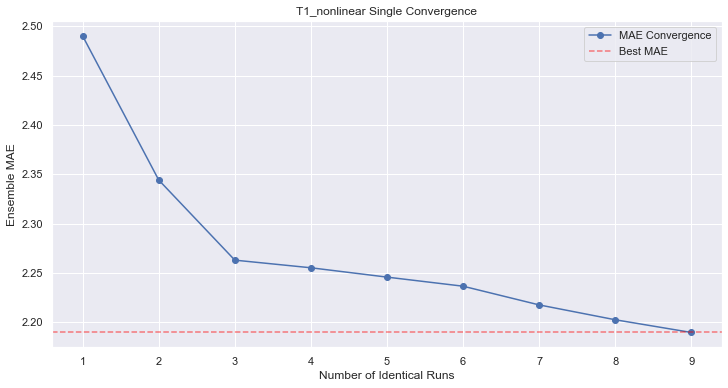

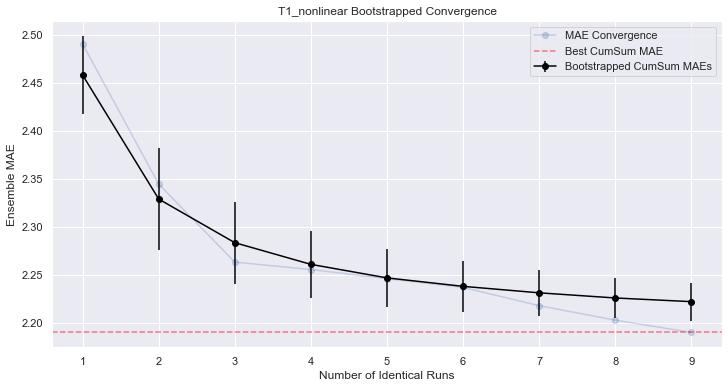

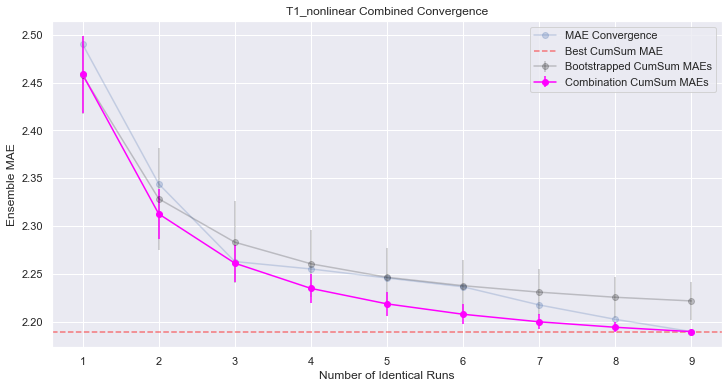

In [26]:
convergencePlots(dfs, 0, names)

% Convergece MAEs
1 0.0
2 0.40636981711158904
3 0.77156823237797
4 0.8230942414203836
5 0.86245333513964
6 0.9597262645866937
7 0.9398669019629463
8 0.9342937158732392
9 1.0
% Bootstrapped MAEs
1 0.0
2 0.5646063375962516
3 0.7460739333492521
4 0.8468431587288863
5 0.9013329255929146
6 0.9391180857331056
7 0.9662436977820485
8 0.9833327587870864
9 1.0
% Combined MAEs
1 0.0
2 0.5648357761603816
3 0.7517793131819273
4 0.8455678284240127
5 0.9019664026508902
6 0.9395434987106632
7 0.9661189517760782
8 0.9853068119924795
9 1.0


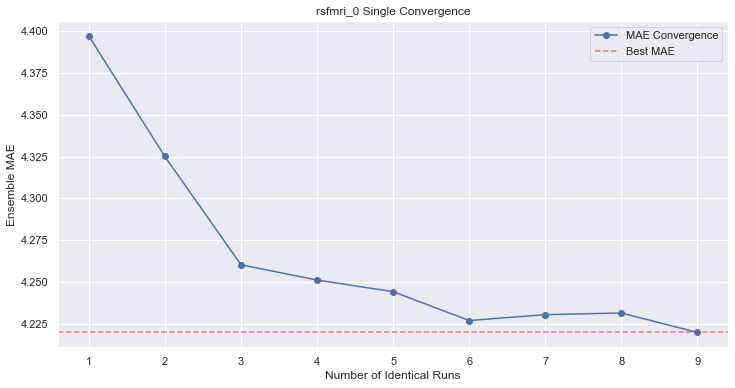

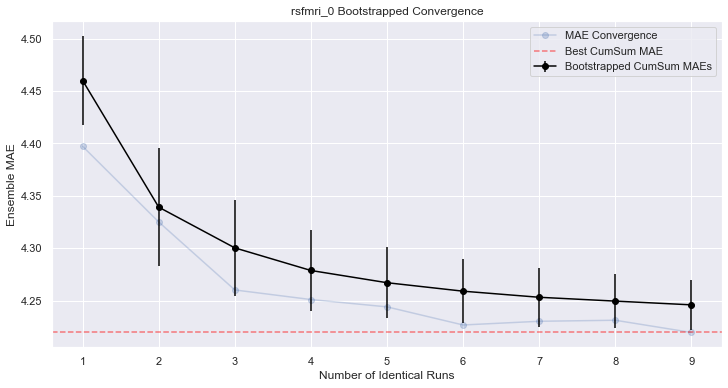

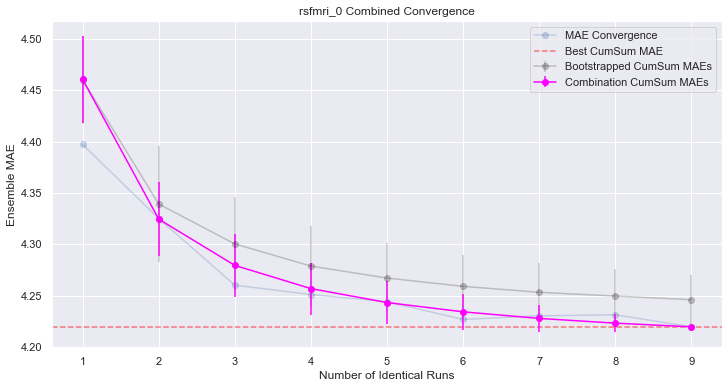

In [27]:
convergencePlots(dfs, 4, names)

% Convergece MAEs
1 0.0
2 0.5270213791740916
3 0.7212086154154236
4 0.8271996318402969
5 0.8833791950584065
6 0.9720558476244799
7 0.9635171067690449
8 0.9985143897227176
9 1.0
% Bootstrapped MAEs
1 0.0
2 0.556023450315756
3 0.7423739240458993
4 0.8393627285292541
5 0.894938301329065
6 0.9349745592959682
7 0.9627126483457317
8 0.9835909411610804
9 1.0
% Combined MAEs
1 0.0
2 0.5518554384057133
3 0.7412574843993401
4 0.8376229584310333
5 0.8960940515191306
6 0.9350526145491453
7 0.9626462677901144
8 0.9837817948149865
9 1.0


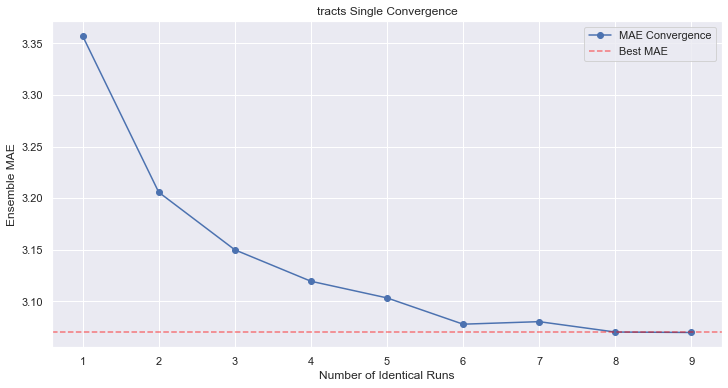

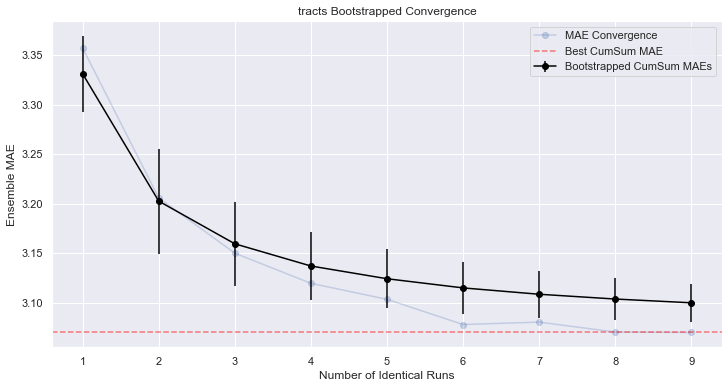

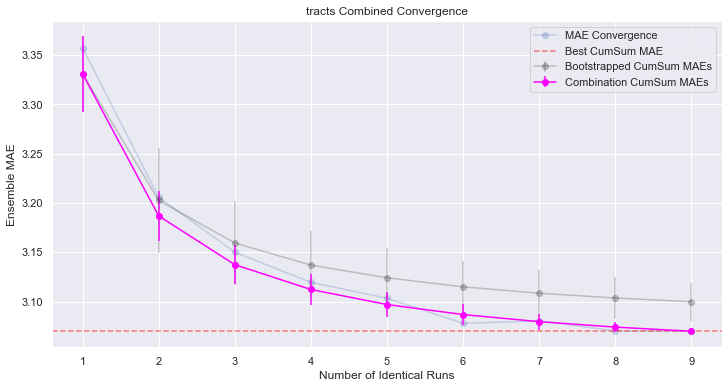

In [28]:
convergencePlots(dfs, 7, names)

% Convergece MAEs
1 0.0
2 0.149283688173933
3 0.555314554265982
4 0.7012525788270696
5 0.7800826568023669
6 0.8600510350588255
7 0.9189709950552785
8 0.9892121386626207
9 1.0
% Bootstrapped MAEs
1 0.0
2 0.5610437099706701
3 0.7532217703368421
4 0.8459397781126248
5 0.901612915939555
6 0.937169212280834
7 0.9662448545748153
8 0.9866435484631395
9 1.0
% Combined MAEs
1 0.0
2 0.556939327852921
3 0.7444752755036145
4 0.8388190300709549
5 0.895710639111087
6 0.9339813385967171
7 0.9618386490212117
8 0.9826455976676969
9 1.0


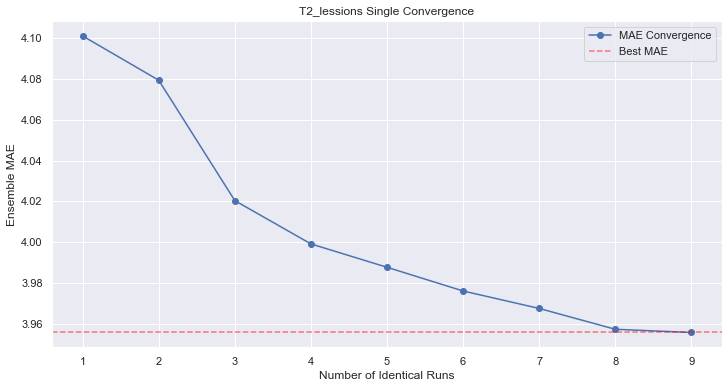

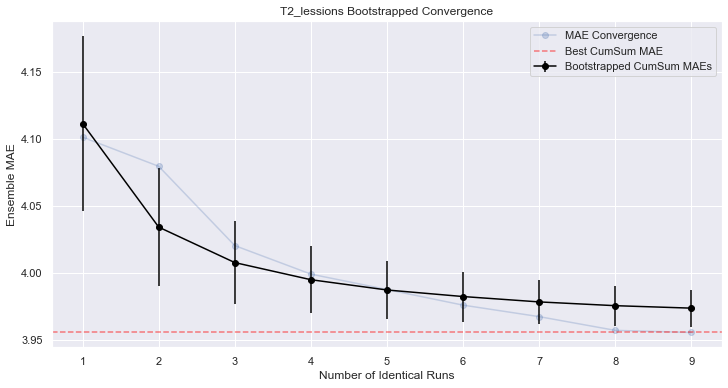

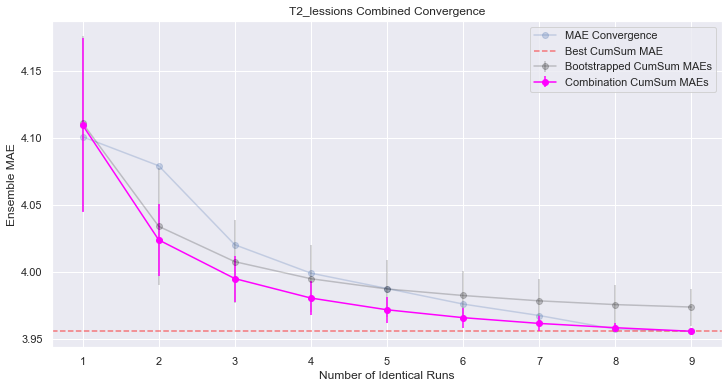

In [32]:
convergencePlots(dfs, 15, names)

% Convergece MAEs
1 0.0
2 0.4371310548852311
3 0.6468927820995015
4 0.7330131533616446
5 0.8326830398372207
6 0.9290593217960936
7 0.9952687590429314
8 1.0004613439337338
9 1.0
% Bootstrapped MAEs
1 0.0
2 0.5573701893716696
3 0.7478260416250009
4 0.8412652506689098
5 0.8993790983690054
6 0.9346144520626455
7 0.9653745328909339
8 0.9832015379070332
9 1.0
% Combined MAEs
1 0.0
2 0.5542431825241109
3 0.7436050360654847
4 0.8398659275518492
5 0.898104997795266
6 0.9368550802851017
7 0.9642860518363942
8 0.9846712228185125
9 1.0


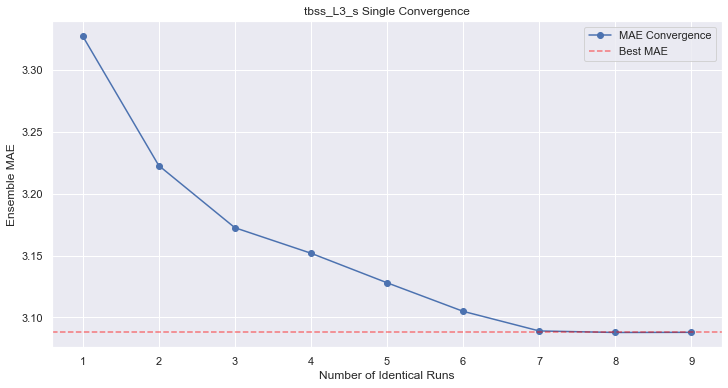

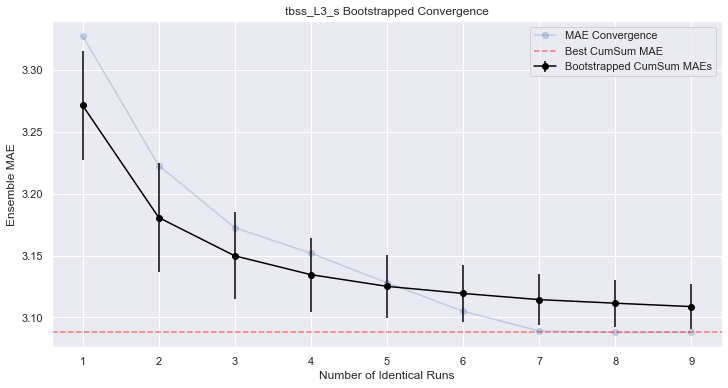

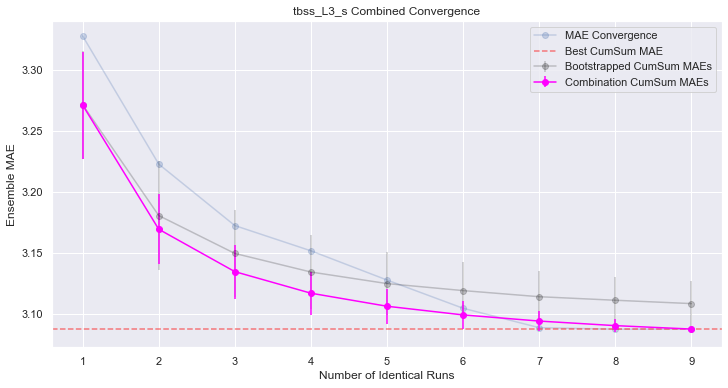

In [33]:
convergencePlots(dfs, 17, names)

In [29]:

net1 = "1" # T1NL
net2 = '2' # T2NL
net3 = '3' # FA
net4 = "4" # MD
net5 = '5' # rsfMRI 0
net6 = '6' # SWI
net7 = "7" # tfMRI 1
net8 = '8' # dmri tracts
net9 = '9' # MO
net10 = "10" # TBSS ISOVF
net11 = '11' # L2
net12 = '12' # rsfMRI 2
net13 = "13" # rsfMRI 10
net14 = '14' # rsfMRI 5
net15 = '21' # rsfMRI 21
net16 = "16" # T2 Lessions
net17 = '17' # TBSS FA
net18 = '18' # TBSS L3

dfs = [
    net1,
    net2,
    net3,
    net4,
    net5,
    net6,
    net7,
    net8,
    net9,
    net10,
    net11,
    net12,
    net13,
    net14,
    net15,
    net16,
    net17,
    net18
]

names = [

    'T1_nonlinear',           #1
    'T2_nonlinear',           #2
    'tbss_FA',                #3
    'tbss_MD',                #4
    'rsfmri_0',               #5
    'swi',                    #6
    'tfmri_1',                #7
    'tracts',                 #8
    'tbss_MO',                #9
    'tbss_ISOVF_s',           #10
    'tbss_L2',                #11
    'rsfmri_2',               #12
    'rsfmri_10',              #13
    'rsfmri_5',               #14
    'rsfmri_21',              #15
    'T2_lessions',            #16
    'tbss_FA_s',              #17
    'tbss_L3_s',              #18
    

]
    
dfs1, dfs2, dfs3 = [], [], []
dfs4, dfs5, dfs6 = [], [], []
dfs7, dfs8, dfs9 = [], [], []

dfs1 = dfs.copy()
dfs2 = dfs.copy()
dfs3 = dfs.copy()
dfs4 = dfs.copy()
dfs5 = dfs.copy()
dfs6 = dfs.copy()
dfs7 = dfs.copy()
dfs8 = dfs.copy()
dfs9 = dfs.copy()


for idx in range(len(dfs)):
    
    dfs1[idx] = '../predictions/AC1-' + dfs1[idx] + '_predictions/output_statistics_test.csv'
    dfs2[idx] = '../predictions/AC2-' + dfs2[idx] + '_predictions/output_statistics_test.csv'
    dfs3[idx] = '../predictions/AC3-' + dfs3[idx] + '_predictions/output_statistics_test.csv'
    dfs4[idx] = '../predictions/AC4-' + dfs4[idx] + '_predictions/output_statistics_test.csv'
    dfs5[idx] = '../predictions/AC5-' + dfs5[idx] + '_predictions/output_statistics_test.csv'
    dfs6[idx] = '../predictions/AC6-' + dfs6[idx] + '_predictions/output_statistics_test.csv'
    dfs7[idx] = '../predictions/AC7-' + dfs7[idx] + '_predictions/output_statistics_test.csv'
    dfs8[idx] = '../predictions/AC8-' + dfs8[idx] + '_predictions/output_statistics_test.csv'
    dfs9[idx] = '../predictions/AC9-' + dfs9[idx] + '_predictions/output_statistics_test.csv'

    
for idx in range(len(dfs)):
    dfs1[idx] = pd.read_csv(dfs1[idx])
    dfs2[idx] = pd.read_csv(dfs2[idx])
    dfs3[idx] = pd.read_csv(dfs3[idx])
    dfs4[idx] = pd.read_csv(dfs4[idx])
    dfs5[idx] = pd.read_csv(dfs5[idx])
    dfs6[idx] = pd.read_csv(dfs6[idx])
    dfs7[idx] = pd.read_csv(dfs7[idx])
    dfs8[idx] = pd.read_csv(dfs8[idx])
    dfs9[idx] = pd.read_csv(dfs9[idx])

    
for idx in range(len(dfs)):
    dfs[idx] = pd.merge(dfs1[idx], dfs2[idx], on='Unnamed: 0', how='inner')
    dfs[idx] = pd.merge(dfs[idx], dfs3[idx], on='Unnamed: 0', how='inner')
    
    dfs[idx].rename({
        'target_age_x': 'target_age_original',
        'output_age_x': 'output_age_1',
        'age_delta_x': 'age_delta_1',
        'loss_x': 'loss_1',
        'target_age_y': 'target_age_2',
        'output_age_y': 'output_age_2',
        'age_delta_y': 'age_delta_2',
        'loss_y': 'loss_2',
        'target_age': 'target_age_3',
        'output_age': 'output_age_3',
        'age_delta': 'age_delta_3',
        'loss': 'loss_3',
    }, axis=1, inplace=True)
    
    dfs[idx].drop(['target_age_2', 'target_age_3'], axis=1, inplace=True)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs4[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_4',
        'age_delta': 'age_delta_4',
        'loss': 'loss_4',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs5[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_5',
        'age_delta': 'age_delta_5',
        'loss': 'loss_5',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs6[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_6',
        'age_delta': 'age_delta_6',
        'loss': 'loss_6',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
      
    
    dfs[idx] = pd.merge(dfs[idx], dfs7[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_7',
        'age_delta': 'age_delta_7',
        'loss': 'loss_7',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs8[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_8',
        'age_delta': 'age_delta_8',
        'loss': 'loss_8',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs9[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_9',
        'age_delta': 'age_delta_9',
        'loss': 'loss_9',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    dfs[idx].rename({
        'target_age_original': 'target_age',
    }, axis=1, inplace=True)
    
    dfs[idx]['mean_output_age'] = dfs[idx][['output_age_1', 'output_age_2', 'output_age_3',
                                           'output_age_4', 'output_age_5', 'output_age_6',
                                           'output_age_7', 'output_age_8', 'output_age_9',
                                           ]].mean(axis=1)
    dfs[idx]['mean_age_delta'] = dfs[idx]['mean_output_age'] - dfs[idx]['target_age']
    
for idx in range(len(dfs)):    
    dfs[idx]['output_age_decon'] = age_debiasing(dfs[idx].mean_output_age, dfs[idx].target_age) 
    dfs[idx]['age_delta_decon'] = dfs[idx].output_age_decon - dfs[idx].target_age
    

d = {'modality':names, 'dataframe':dfs}
df = pd.DataFrame(data=d)
df.to_pickle('female_test_testAB_convergence9.pkl', protocol = 4)

In [30]:
df

,modality,dataframe
0,T1_nonlinear,Unnamed: 0 target_age output_age_1 ag...
1,T2_nonlinear,Unnamed: 0 target_age output_age_1 ag...
2,tbss_FA,Unnamed: 0 target_age output_age_1 ag...
3,tbss_MD,Unnamed: 0 target_age output_age_1 ag...
4,rsfmri_0,Unnamed: 0 target_age output_age_1 ag...
5,swi,Unnamed: 0 target_age output_age_1 ag...
6,tfmri_1,Unnamed: 0 target_age output_age_1 ag...
7,tracts,Unnamed: 0 target_age output_age_1 ag...
8,tbss_MO,Unnamed: 0 target_age output_age_1 ag...
9,tbss_ISOVF_s,Unnamed: 0 target_age output_age_1 ag...


In [31]:
df.iloc[1].dataframe

,Unnamed: 0,target_age,output_age_1,age_delta_1,loss_1,output_age_2,age_delta_2,loss_2,output_age_3,age_delta_3,...,output_age_8,age_delta_8,loss_8,output_age_9,age_delta_9,loss_9,mean_output_age,mean_age_delta,output_age_decon,age_delta_decon
0,24806531,67.670662,68.509550,0.838890,0.703736,73.236336,5.565674,30.976723,72.469410,4.798752,...,68.385210,0.714546,0.510576,68.307884,0.637222,0.406052,70.254939,2.584277,71.200289,3.529627
1,24237795,77.280936,76.850940,-0.429999,0.184899,74.938800,-2.342139,5.485615,78.419160,1.138223,...,76.484510,-0.796424,0.634291,72.245290,-5.035643,25.357705,75.510457,-1.770479,77.303438,0.022502
2,24748274,58.301941,60.355747,2.053807,4.218121,59.923730,1.621788,2.630197,58.820050,0.518109,...,60.285904,1.983963,3.936110,58.482098,0.180157,0.032457,58.926985,0.625045,58.045319,-0.256622
3,25463415,58.056694,61.848972,3.792278,14.381375,62.835796,4.779102,22.839819,60.216755,2.160061,...,61.388626,3.331932,11.101772,61.533825,3.477131,12.090440,61.313840,3.257146,60.817134,2.760440
4,25313661,59.653082,60.947903,1.294820,1.676560,60.419190,0.766107,0.586920,57.766880,-1.886202,...,58.878983,-0.774100,0.599230,58.499160,-1.153921,1.331535,58.887667,-0.765415,57.999659,-1.653423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,25475074,59.848516,62.857624,3.009108,9.054731,62.820805,2.972289,8.834500,60.481663,0.633147,...,58.802933,-1.045583,1.093244,61.883835,2.035319,4.142523,61.458508,1.609992,60.985135,1.136619
5016,22834218,60.501941,57.904080,-2.597861,6.748883,58.575005,-1.926936,3.713083,56.741596,-3.760344,...,57.548110,-2.953830,8.725110,57.353070,-3.148871,9.915391,57.373589,-3.128352,56.241384,-4.260556
5017,24442683,56.130708,50.748410,-5.382298,28.969137,51.016910,-5.113797,26.150922,51.090538,-5.040170,...,52.947098,-3.183610,10.135373,51.122650,-5.008058,25.080641,51.428653,-4.702054,49.337627,-6.793081
5018,21157566,78.016553,75.256096,-2.760457,7.620121,78.811740,0.795185,0.632318,75.354380,-2.662175,...,77.130936,-0.885617,0.784317,75.923960,-2.092595,4.378953,76.350483,-1.666070,78.278946,0.262393


In [17]:
# from scipy.stats import pearsonr

In [32]:
# pearsonr(df.iloc[0].dataframe.mean_age_delta, df.iloc[2].dataframe.mean_age_delta)

In [33]:
# df.iloc[0].dataframe.to_csv('female_test_testAB_convergence_T1.csv')
# df.iloc[1].dataframe.to_csv('female_test_testAB_convergence_T2.csv')
# df.iloc[2].dataframe.to_csv('female_test_testAB_convergence_FA.csv')

In [34]:
# df.iloc[0].dataframe[['Unnamed: 0', 'target_age', 'mean_output_age']].to_csv('female_test_testAB_convergence_T1.csv')
# df.iloc[1].dataframe[['Unnamed: 0', 'target_age', 'mean_output_age']].to_csv('female_test_testAB_convergence_T2.csv')
# df.iloc[2].dataframe[['Unnamed: 0', 'target_age', 'mean_output_age']].to_csv('female_test_testAB_convergence_FA.csv')

In [35]:
# df.iloc[0].dataframe[['Unnamed: 0', 'target_age', 'mean_output_age']]